In [1]:
import os
import pandas as pd
from sklearn.model_selection import  StratifiedKFold
from catboost import CatBoostClassifier
from autofeat import AutoFeatClassifier
import numpy as np
import optuna
from collections import defaultdict
from statistics import median, mode
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import joblib

C:\Users\aygul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def objective(trial: optuna.Trial) -> float:
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        'depth': trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-10, 100),
        "random_state": 42,
        "verbose": False,
    }

    model = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits=2) 
    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train_transform, y_train)):
        train_x = X_train_transform.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train_transform.iloc[val_index]
        val_y = y_train.iloc[val_index]
        model.fit(train_x, train_y)
        y_pred = model.predict(val_x)

        metrics['score'].append(roc_auc_score(val_y, y_pred))

    return median(np.array(metrics['score']))

In [9]:
def extract_features(row:pd.Series)->pd.Series:
    values = np.array(row['values'])
    features = {
        'feature_median': np.median(values),
        'feature_mode': mode(values),
        'feature_q_5': np.quantile(values, 0.05, axis=0),
        'feature_q_25': np.quantile(values, 0.25, axis=0),
        'feature_q_75': np.quantile(values, 0.75, axis=0),
        'feature_q_95': np.quantile(values, 0.95, axis=0),
        'feature_std': np.std(values),
        'feature_autocorr': pd.Series(values).autocorr(lag=1)
    }
    return pd.Series(features)

In [4]:
data_train = pd.read_parquet('train.parquet')

In [5]:
data_train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [10]:
df_train = data_train.apply(extract_features, axis=1)

C:\Users\aygul\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aygul\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
df_train['label'] = data_train['label']
df_train['id'] = data_train['id']

# EDA

In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feature_median    79912 non-null  float64
 1   feature_mode      79912 non-null  float64
 2   feature_q_5       79912 non-null  float64
 3   feature_q_25      79912 non-null  float64
 4   feature_q_75      79912 non-null  float64
 5   feature_q_95      79912 non-null  float64
 6   feature_std       79912 non-null  float64
 7   feature_autocorr  79897 non-null  float64
 8   label             80000 non-null  float64
 9   id                80000 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 6.1 MB


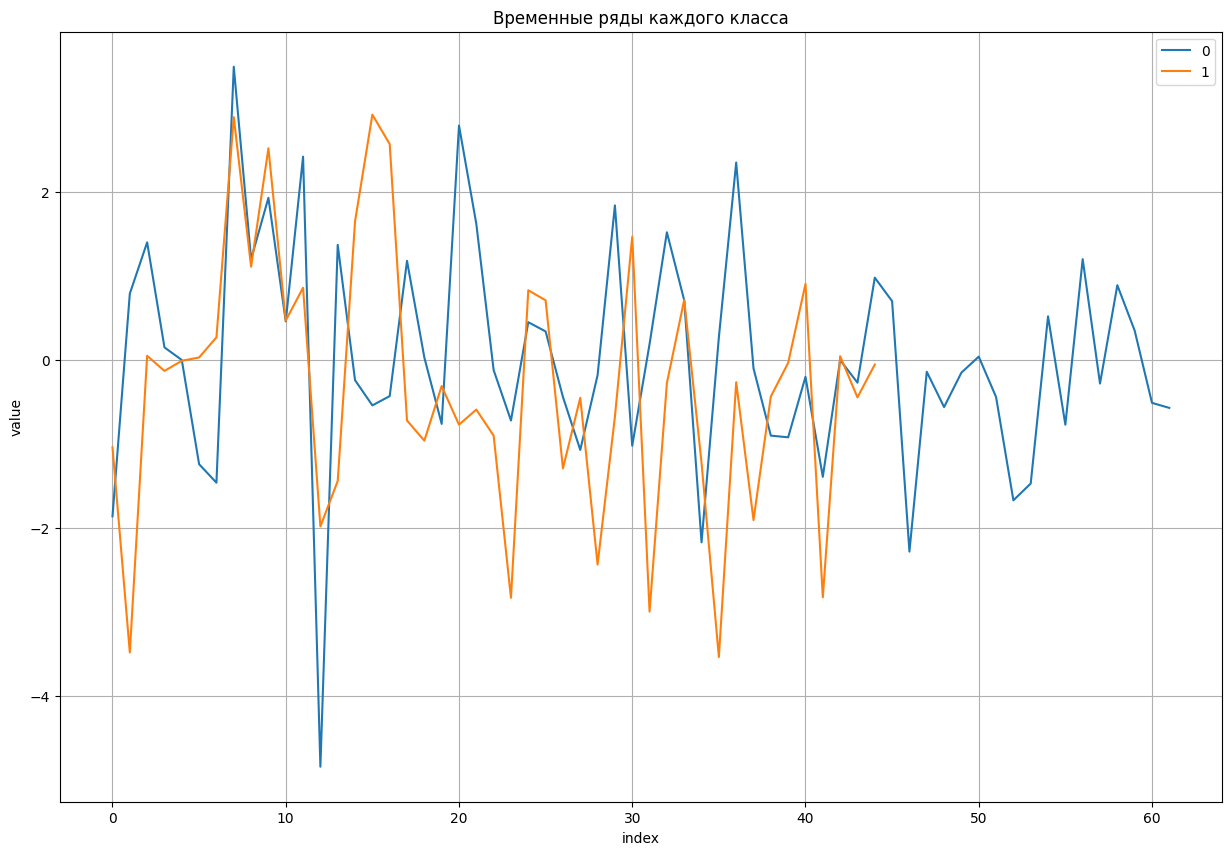

In [35]:
data_0 = data_train[data_train['label'] == 0]['values'].iloc[0]
data_1 = data_train[data_train['label'] == 1]['values'].iloc[0]

plt.figure(figsize=(15, 10))
plt.plot(data_0, label="0")
plt.plot(data_1, label="1")
plt.legend()
plt.title("Временные ряды каждого класса")
plt.xlabel("index")
plt.ylabel("value")
plt.grid()
plt.show()

In [36]:
df_train.describe()

,feature_median,feature_mode,feature_q_5,feature_q_25,feature_q_75,feature_q_95,feature_std,feature_autocorr,label,id
count,79912.000000,79912.000000,79912.000000,79912.000000,79912.000000,79912.000000,79912.000000,79897.000000,80000.000000,80000.000000
mean,-0.098078,-0.039165,-1.821949,-0.850784,0.727335,1.962708,1.214052,0.401909,0.277250,50107.893162
std,0.204955,0.897476,0.465822,0.229380,0.282160,0.390028,0.137702,0.225952,0.447644,28857.649778
min,-1.190068,-4.520000,-4.482500,-2.010068,-0.550000,-0.220000,0.816815,-0.521248,0.000000,0.000000
25%,-0.235000,-0.650000,-2.112000,-0.994996,0.602500,1.742000,1.110445,0.255893,0.000000,25122.500000
50%,-0.100000,-0.120000,-1.856000,-0.850000,0.762500,1.972500,1.210340,0.407155,0.000000,50146.500000
75%,0.040000,0.540000,-1.585294,-0.710000,0.902500,2.206000,1.308255,0.545465,1.000000,75064.250000
max,0.870000,5.340000,0.200000,0.530000,1.972500,3.800000,1.921515,0.997638,1.000000,99999.000000


In [37]:
df_train.label.value_counts()

label
0.0    57820
1.0    22180
Name: count, dtype: int64

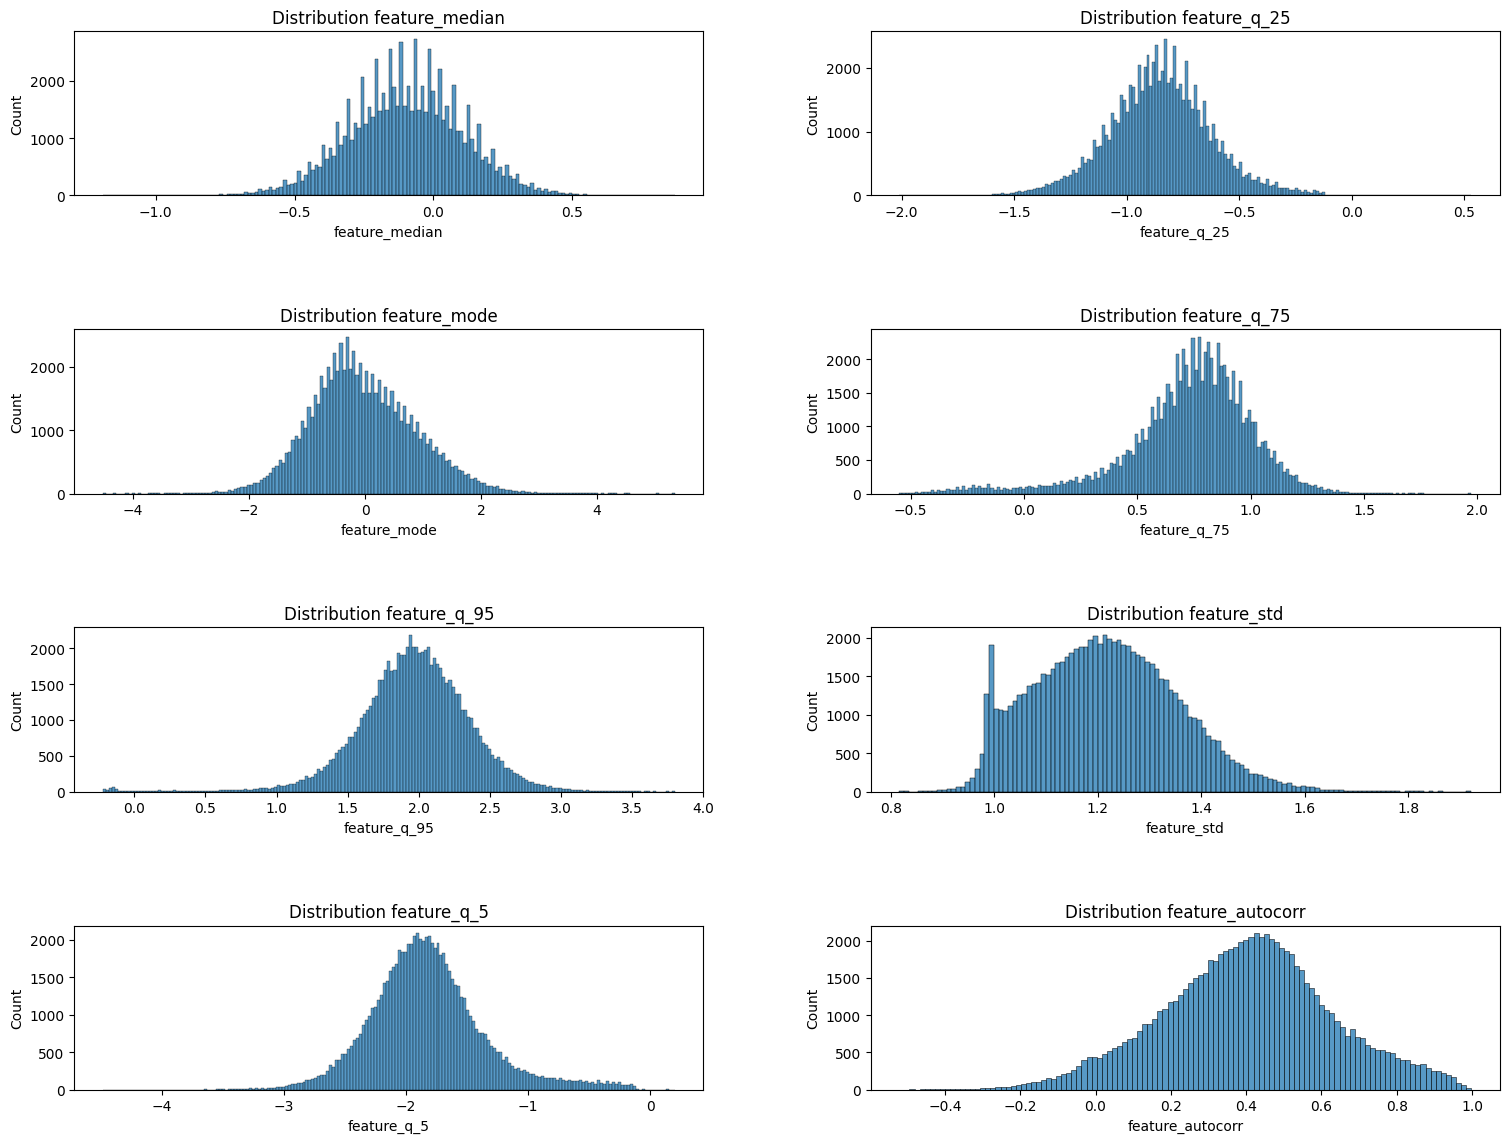

In [38]:
fig, axs = plt.subplots(4, 2)
fig.tight_layout(pad=1.6) 
fig.set_size_inches(16.5, 12.5, forward=True) 

sns.histplot(df_train['feature_median'], ax=axs[0, 0])
axs[0, 0].set_title(f"Distribution feature_median")

sns.histplot(df_train['feature_mode'], ax=axs[1, 0])
axs[1, 0].set_title(f"Distribution feature_mode")

sns.histplot(df_train['feature_q_25'], ax=axs[0, 1])
axs[0, 1].set_title(f"Distribution feature_q_25")

sns.histplot(df_train['feature_q_75'], ax=axs[1, 1])
axs[1, 1].set_title(f"Distribution feature_q_75")

sns.histplot(df_train['feature_q_95'], ax=axs[2, 0])
axs[2, 0].set_title(f"Distribution feature_q_95")

sns.histplot(df_train['feature_std'], ax=axs[2, 1])
axs[2, 1].set_title(f"Distribution feature_std")

sns.histplot(df_train['feature_q_5'], ax=axs[3, 0])
axs[3, 0].set_title(f"Distribution feature_q_5")

sns.histplot(df_train['feature_autocorr'], ax=axs[3, 1])
axs[3, 1].set_title(f"Distribution feature_autocorr")
plt.show()

Видим, что признаки распределены нормально, за исключением дополнительного пика у признака feature_std

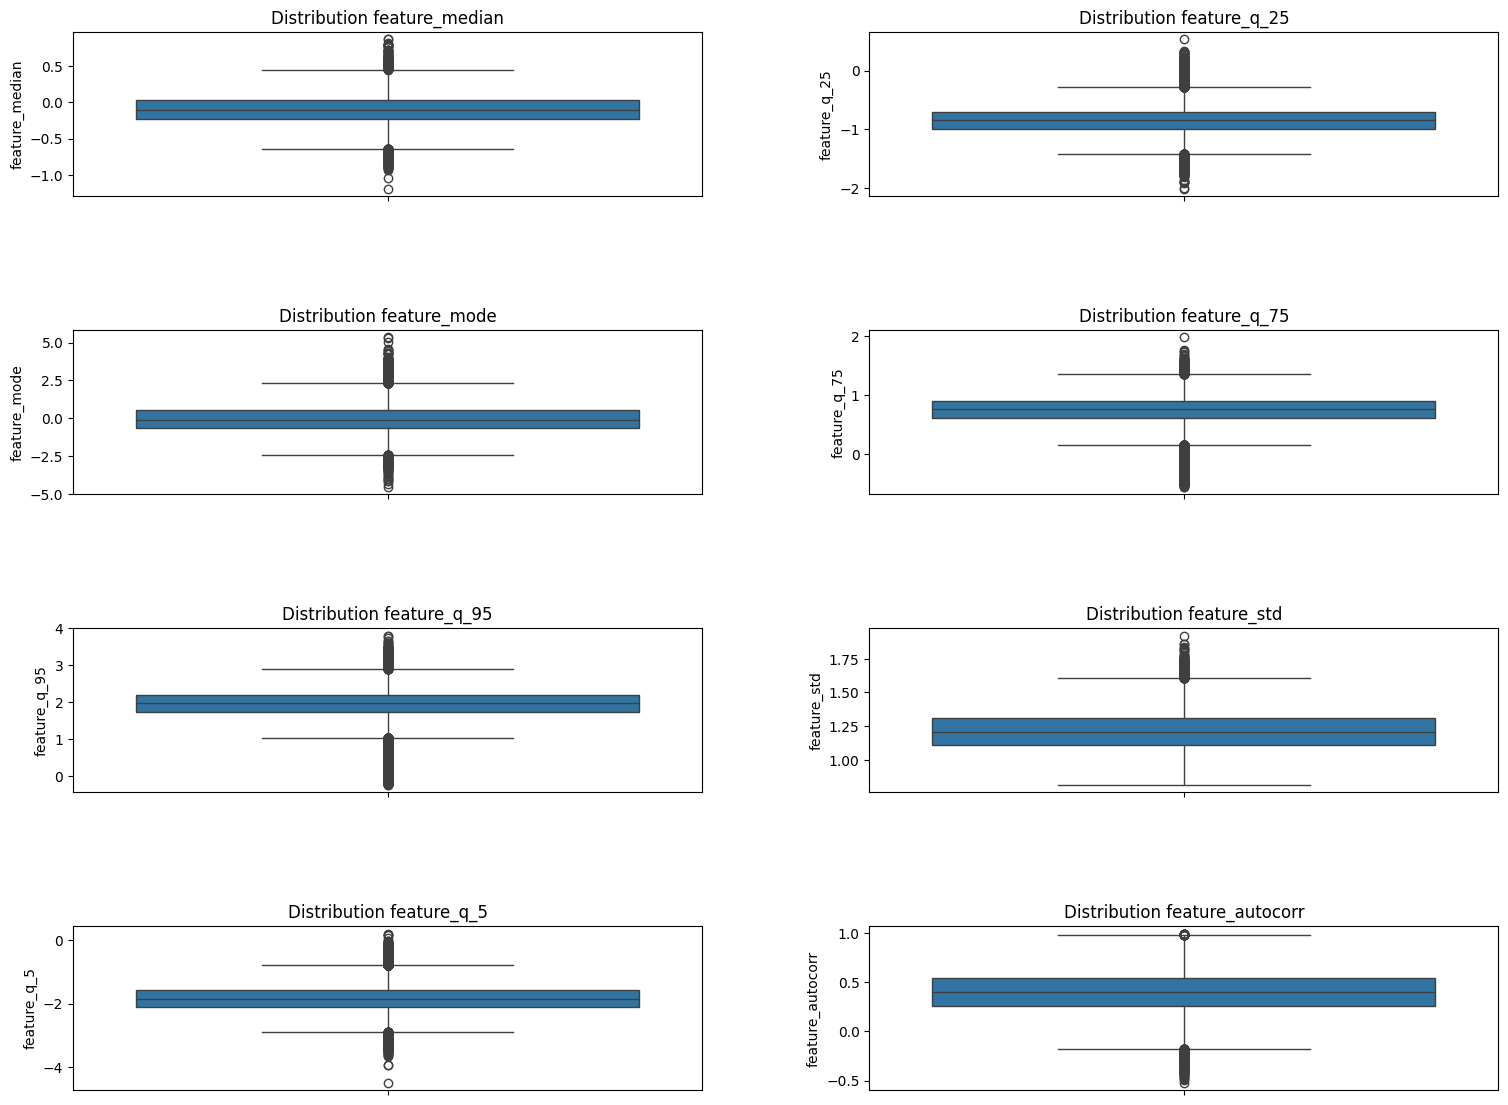

In [39]:
fig, axs = plt.subplots(4, 2)
fig.tight_layout(pad=1.6) 
fig.set_size_inches(16.5, 12.5, forward=True) 

sns.boxplot(df_train['feature_median'], ax=axs[0, 0])
axs[0, 0].set_title(f"Distribution feature_median")

sns.boxplot(df_train['feature_mode'], ax=axs[1, 0])
axs[1, 0].set_title(f"Distribution feature_mode")

sns.boxplot(df_train['feature_q_25'], ax=axs[0, 1])
axs[0, 1].set_title(f"Distribution feature_q_25")

sns.boxplot(df_train['feature_q_75'], ax=axs[1, 1])
axs[1, 1].set_title(f"Distribution feature_q_75")

sns.boxplot(df_train['feature_q_95'], ax=axs[2, 0])
axs[2, 0].set_title(f"Distribution feature_q_95")

sns.boxplot(df_train['feature_std'], ax=axs[2, 1])
axs[2, 1].set_title(f"Distribution feature_std")

sns.boxplot(df_train['feature_q_5'], ax=axs[3, 0])
axs[3, 0].set_title(f"Distribution feature_q_5")

sns.boxplot(df_train['feature_autocorr'], ax=axs[3, 1])
axs[3, 1].set_title(f"Distribution feature_autocorr")
plt.show()

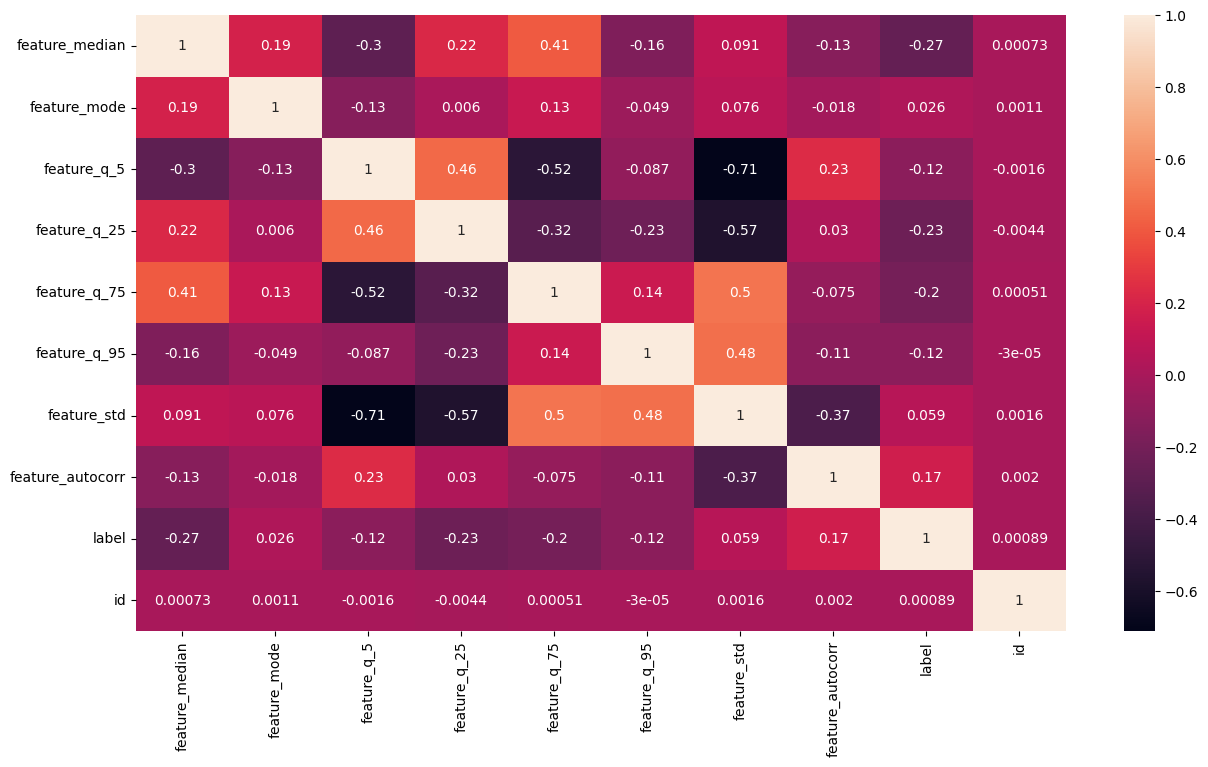

In [40]:
plt.figure(figsize=(15, 8)) 
sns.heatmap(df_train.corr(), annot=True)
plt.show()

# Preprocessing and feature engineering

In [13]:
df_train_preproc = df_train.dropna()

In [14]:
df_train_preproc.reset_index(drop=True, inplace=True)

In [15]:
df_train_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79897 entries, 0 to 79896
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feature_median    79897 non-null  float64
 1   feature_mode      79897 non-null  float64
 2   feature_q_5       79897 non-null  float64
 3   feature_q_25      79897 non-null  float64
 4   feature_q_75      79897 non-null  float64
 5   feature_q_95      79897 non-null  float64
 6   feature_std       79897 non-null  float64
 7   feature_autocorr  79897 non-null  float64
 8   label             79897 non-null  float64
 9   id                79897 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 6.1 MB


In [16]:
df_train_preproc['label'] = df_train_preproc['label'].astype(int)

C:\Users\aygul\AppData\Local\Temp\ipykernel_15140\1979560777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_preproc['label'] = df_train_preproc['label'].astype(int)


In [17]:
X_train, y_train = df_train_preproc.drop(columns=['label']), df_train_preproc['label']

In [18]:
list_num_features = X_train.select_dtypes(['float']).columns

In [41]:
transformations = ('1/', '^2', '^3')
afc = AutoFeatClassifier(feateng_steps=1, n_jobs=-1, verbose=0, transformations=transformations)

In [20]:
X_train_transform = afc.fit_transform(X_train[list_num_features], y_train)

In [21]:
X_train_transform.head()

,feature_median,feature_mode,feature_q_5,feature_q_25,feature_q_75,feature_q_95,feature_std,feature_autocorr,feature_q_75**3,feature_median**2,feature_autocorr**3,1/feature_q_5
0,-0.110000,0.00,-1.850500,-0.6825,0.7700,2.3290,1.337272,-0.113649,0.456533,0.012100,-0.001468,-0.540394
1,-0.274409,-1.04,-2.961527,-1.0400,0.7100,2.5600,1.556337,0.189858,0.357911,0.075300,0.006844,-0.337664
2,-0.145000,-0.51,-1.714500,-0.8775,0.6150,1.6265,1.065023,0.501409,0.232608,0.021025,0.126060,-0.583260
3,-0.345000,-0.95,-1.988000,-0.9500,0.8250,1.5445,1.158201,0.705215,0.561516,0.119025,0.350724,-0.503018
4,-0.475000,-0.54,-2.107500,-1.2500,0.6775,1.8425,1.270529,0.088913,0.310977,0.225625,0.000703,-0.474496


# Model training

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

In [24]:
best_params = study.best_params

In [25]:
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_transform, y_train)

0:	learn: 0.5954601	total: 31.1ms	remaining: 41.5s
1:	learn: 0.5469169	total: 58.5ms	remaining: 39s
2:	learn: 0.5159169	total: 87.1ms	remaining: 38.6s
3:	learn: 0.4962661	total: 114ms	remaining: 37.9s
4:	learn: 0.4822907	total: 141ms	remaining: 37.5s
5:	learn: 0.4735498	total: 166ms	remaining: 36.8s
6:	learn: 0.4669227	total: 190ms	remaining: 36s
7:	learn: 0.4611613	total: 215ms	remaining: 35.6s
8:	learn: 0.4571701	total: 241ms	remaining: 35.5s
9:	learn: 0.4533694	total: 271ms	remaining: 35.9s
10:	learn: 0.4514236	total: 297ms	remaining: 35.8s
11:	learn: 0.4485610	total: 322ms	remaining: 35.4s
12:	learn: 0.4469046	total: 346ms	remaining: 35.2s
13:	learn: 0.4453437	total: 374ms	remaining: 35.3s
14:	learn: 0.4441898	total: 402ms	remaining: 35.4s
15:	learn: 0.4424791	total: 428ms	remaining: 35.3s
16:	learn: 0.4405205	total: 456ms	remaining: 35.3s
17:	learn: 0.4394931	total: 487ms	remaining: 35.6s
18:	learn: 0.4383689	total: 514ms	remaining: 35.6s
19:	learn: 0.4375491	total: 541ms	remainin

In [26]:
print('Score on train:', roc_auc_score(y_train, best_model.predict_proba(X_train_transform)[:, 1]))

Score on train: 0.913051014662986


In [42]:
with open('fitted_model.pkl', 'wb') as fd:
    joblib.dump(best_model, fd) 